In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/tn_ev_registrations_public.csv')

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2019-03-31,7079.0
2019-06-30,7118.0
2019-09-30,8998.0
2019-12-31,9506.0
2020-03-31,7972.0
2020-06-30,9119.0
2020-09-30,9780.0
2020-12-31,10858.0
2021-03-31,12004.0


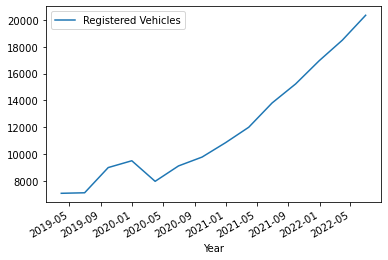

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

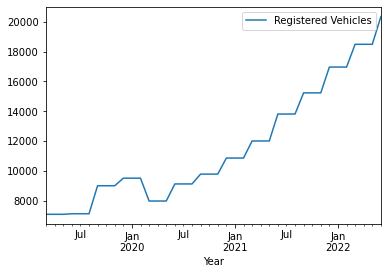

In [7]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(1.1489286654775244,
 0.995613317487595,
 3,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 460.8936068948409)

## Modeling

In [13]:
# Splitting Training and Testing data; using after 2019 as test

train = df[:'2021-05']
test = df['2021-06':]
combined = df

test

,Registered Vehicles
Year,
2021-06-30,13813.0
2021-07-31,13813.0
2021-08-31,13813.0
2021-09-30,15236.0
2021-10-31,15236.0
2021-11-30,15236.0
2021-12-31,16968.0
2022-01-31,16968.0
2022-02-28,16968.0


In [14]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=571.994, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=436.301, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=438.301, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=434.847, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=456.291, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=432.720, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=477.047, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=434.748, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best mode

### The best model is :  ARIMA (1, 0, 0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0191      0.014     75.036      0.000       0.993       1.046
sigma2      3.683e+05   6.66e+04      5.533      0.000    2.38e+05    4.99e+05


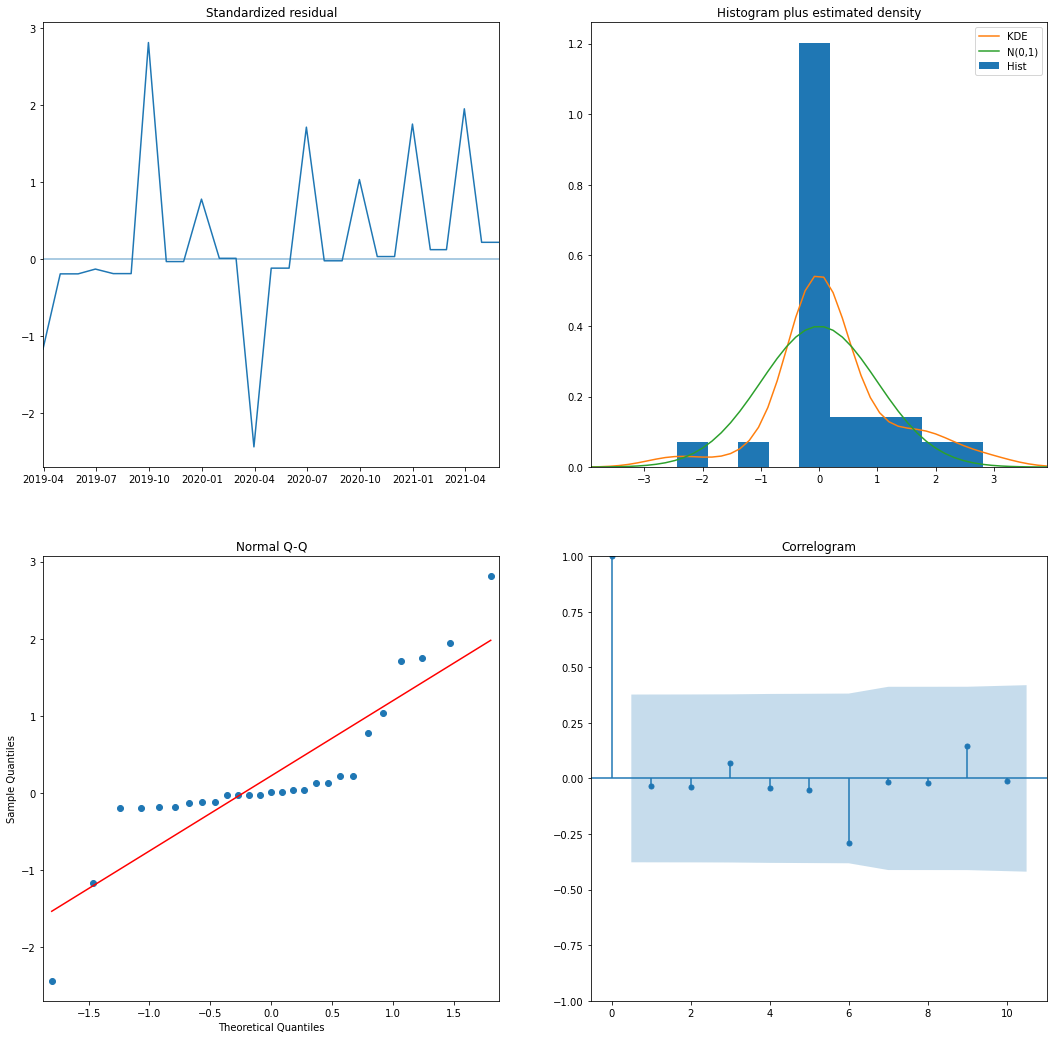

In [16]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [17]:
pred = output.get_prediction(start=pd.to_datetime('2021-06-30'), end=pd.to_datetime('2022-06-30'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2021-06-30,11044.207436,13423.066849
2021-07-31,10769.394013,14165.940498
2021-08-31,10606.108260,14806.240494
2021-09-30,10500.699199,15397.789105
2021-10-31,10432.602628,15961.325100
2021-11-30,10391.383131,16507.461804
2021-12-31,10370.910372,17042.510862
2022-01-31,10367.237726,17570.603677
2022-02-28,10377.659454,18094.634305
2022-03-31,10400.233633,18616.736581


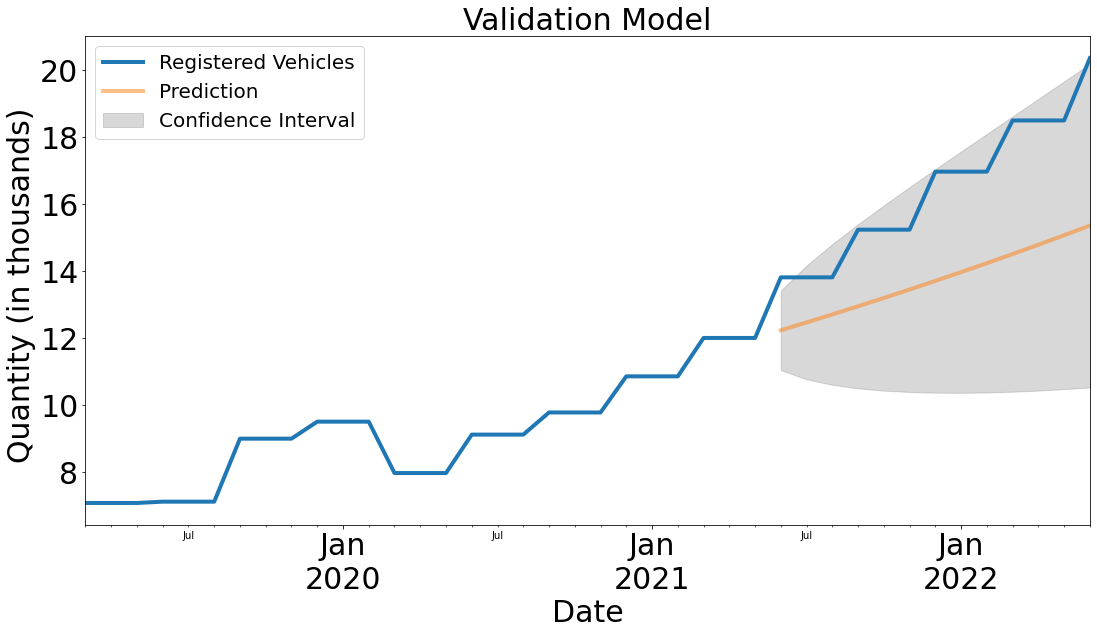

In [18]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()